<h2> Two Mirror Cavity Dynamics</h2>
This notebook tests the ability of finesse to compute the eigenmode change of a linear cavity as a result of an optic being pitched or yawed.

In [2]:
import pykat
from pykat import finesse
from pykat.commands import *
import matplotlib.pyplot as plt
import numpy as np

plt.rc('font', size= 20)
plt.rc('axes', titlesize= 20)

<h2> Analytical Solution </h2>
Here we look at the expected translation of a cavity axis using geometrical arguments. All formulas and how they arise can be found in Siegman chapter 19. The index for each variable indicates which optic we are referring to.

In [3]:
# Mirror Tilt:
npoints = 100
theta_2_low = -1e-6
theta_2_high = 1e-6

theta_1 = 0                     # M1 tilt 
theta_2 = np.linspace(theta_2_low,theta_2_high,npoints+1,endpoint=True) # M2 tilt 

# Cavity parameters:
L = 0.1                        # Cavity Length
RcM2 = 0.5                     # Radius of curvature of M2 mirror =0.5 m
g1 = 1                         # g1 = 1 - L/RcM1 = 1 since RcM1 = infinity
g2 = 1 - L/RcM2                # g2 for M2 mirror
print('g1g2 =', g1*g2)         # Stability check

# Resulant translation 
delta_x1 = (g2/(1-g1*g2))*L*theta_1 + (1/(1- g1*g2))*L*theta_2    # Displacement on M1
delta_x2 = (1/(1-g1*g2))*L*theta_1 + (g1/(1-g1*g2))*L*theta_2     # Displacement on M2
delta_theta = (delta_x2 - delta_x1)/L                             # Angular displacement of optical axis

print('Results for analytical solutions:')
print('∆x1: ', max(delta_x1), min(delta_x1), ' m')
print('∆x2: ', max(delta_x2), min(delta_x2), ' m')
print(r'∆θ: ', max(delta_theta), min(delta_theta), ' m')

g1g2 = 0.8
Results for analytical solutions:
∆x1:  5.000000000000001e-07 -5.000000000000001e-07  m
∆x2:  5.000000000000001e-07 -5.000000000000001e-07  m
∆θ:  0.0 0.0  m


<h2> Finesse Solution </h2>
Now we use finesse to model the same cavity.

In [4]:
# Finesse Solution
base = finesse.kat()
#base.verbose=False
base.parse(
f"""
l laser 1 0 n0              # Laser 1W
s s0 1 n0 n1                # Distance from the laser to the first mirror M1
    
#Cavity:
m M1 0.99 0.01 0 n1 n2      # Cavity mirror M1: R = 0.999, T = 0.01
s s_cav {L} n2 n3           # Cavity Length: L =  0.1 m
m M2 1 0 0 n3 n4            # Cavity mirror M2: R = 1, T = 0
attr M2 Rc {RcM2}              # Radius of curvature of M2 = 0.5 m
cav cavity M1 n2 M2 n3      
"""
)

base.maxtem = 3
base.trace = 2

# We need amplitude detectors for the HG00, HG01, and HG10 modes in order to measure translation
kat = base.deepcopy()
kat.noxaxis = True
kat.parse(
f"""
# Mirror Movement

# Detectors:    
ad det00_1 0 0 0 n2
ad det00_2 0 0 0 n3*
ad det10_1 1 0 0 n2
ad det10_2 1 0 0 n3*
bp bp_n2 x w n2
bp bp_n3 x w n3*
bp cavwaist x w0 n2

pd pcirc n2

# Mirror tilt and axes
xaxis M2 xbeta lin {theta_2_low} {theta_2_high} {npoints}    
yaxis re:im
""")

out = kat.run()
print(out.stdout)
out.info()

--------------------------------------------------------------
Running kat - Started at 2019-08-28 08:59:48.430695

Finished in 0.0818331 seconds

------------------------------------------------------------------------
                     FINESSE 2.2                 (build 2.2-31-ge114168)
       o_.-=.        Frequency domain INterferomEter Simulation SoftwarE
      (\'".\|        13.08.2019         http://www.gwoptics.org/finesse/
      .>' (_--.      
   _=/d   ,^\        Input file /tmp/tmpa29l4wk1.kat,
  ~~ \)-'   '        Output file /tmp/tmpa29l4wk1.out,
     / |             Gnuplot file /tmp/tmpa29l4wk1.gnu 
    '  '                                        Wed Aug 28 08:59:48 2019
------------------------------------------------------------------------
 --- cavity tracing
 cavity cavity:
  cavity is stable! Eigenvalues:
  q=0.2j, w0=260.26206750103um z=0m m=0.6
  finesse : 625.17, round-trip power loss: 0.01 [%/100]
  opt. length: 200mm, FSR: 1.49896229GHz, m: 600m
  FWHM: 2.3

100% | ETA:  0:00:00 | Saving data                                             

In [22]:
%matplotlib inline
#print(out.y.shape)

acirc = np.sqrt(out['pcirc'].real)


intermodal_phase_1 = np.angle(out['det00_1']) - np.angle(out['det10_1'])
intermodal_phase_2 = np.angle(out['det00_2']) - np.angle(out['det10_2'])

# print (intermodal_phase_2)

a_shift_1 = (np.abs(out['det10_1'])/acirc)*np.cos(intermodal_phase_1)
a_shift_2 = (np.abs(out['det10_2'])/acirc)*np.cos(intermodal_phase_2)

# print (np.abs(out['det10_2']))

a_tilt_1 = (np.abs(out['det10_1'])/acirc)*np.sin(intermodal_phase_1)
a_tilt_2 = (np.abs(out['det10_2'])/acirc)*np.sin(intermodal_phase_2)

# print (a_tilt_2)

#dx_finesse_old = w0*(np.abs(out['det10']))/(np.sqrt(out['pcirc'].real))
dx_finesse_1 = out['bp_n2'].real*a_shift_1
dx_finesse_2 = out['bp_n3'].real*a_shift_2

dtheta_1 = a_tilt_1*1.064e-6/(np.pi*out['cavwaist'].real)
dtheta_2 = a_tilt_2*1.064e-6/(np.pi*out['cavwaist'].real)

print('Results for finesse solutions:')
print('Intermodal_1: ', max(intermodal_phase_1/np.pi), min(dx_finesse_1/np.pi), ' pi')
print('Intermodal_2: ', max(intermodal_phase_2/np.pi), min(dx_finesse_2/np.pi), ' pi')
print (max(out['det00_1'].real/acirc),max(out['det00_1'].imag/acirc))
print (max(a_shift_1),max(a_shift_2))

print('∆x1: ', max(dx_finesse_1), min(dx_finesse_1), ' m')
print('∆x2: ', max(dx_finesse_2), min(dx_finesse_2), ' m')
print(r'∆θ1: ', max(dtheta_1), min(dtheta_1), ' m')
print(r'∆θ2: ', max(dtheta_2), min(dtheta_2), ' m')

Results for finesse solutions:
Intermodal_1:  1.0016000218298082 -1.5875121951722917e-07  pi
Intermodal_2:  0.854016404179375 -1.591502136532752e-07  pi
0.0005860726060129146 0.9999999999999976
0.00191626720625269 0.0017182692446188023
∆x1:  4.987316649837477e-07 -4.987316649837477e-07  m
∆x2:  4.999851420303753e-07 -4.999851420303753e-07  m
∆θ1:  1.2534770466280734e-08 -1.253477046628043e-08  m
∆θ2:  1.1039864658973262e-06 -1.1039864658973262e-06  m


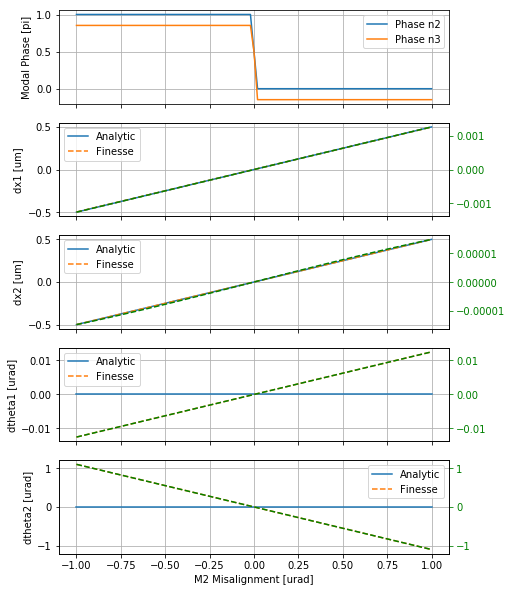

In [6]:
fig, ax = plt.subplots(nrows=5,sharex=True,figsize=(7,10))

xaxis = 1e6*out.x

## Plot phases
ax[0].plot(xaxis,intermodal_phase_1/np.pi,label='Phase n2')
ax[0].plot(xaxis,intermodal_phase_2/np.pi,label='Phase n3')
ax[0].set_ylabel('Modal Phase [pi]')

# Plot dx1
ax[1].plot(xaxis,1e6*delta_x1,'-',label='Analytic')
ax[1].plot(xaxis,1e6*dx_finesse_1,'--',label='Finesse')
ax[1].set_ylabel('dx1 [um]')

# Plot dx1 err
ax1_2 = ax[1].twinx()
ax1_2.plot(xaxis,1e6*(delta_x1 - dx_finesse_1),'g--')
ax1_2.tick_params(axis='y', colors='g')

# plot dx2
ax[2].plot(xaxis,1e6*delta_x2,'-',label='Analytic')
ax[2].plot(xaxis,1e6*dx_finesse_2,'--',label='Finesse')
ax[2].set_ylabel('dx2 [um]')

# plot dx2 err
ax2_2 = ax[2].twinx()
ax2_2.plot(xaxis,1e6*(delta_x2 - dx_finesse_2),'g--')
ax2_2.tick_params(axis='y', colors='g')

# plot dtheta1
ax[3].plot(xaxis,1e6*delta_theta,'-',label='Analytic')
ax[3].plot(xaxis,1e6*dtheta_1,'--',label='Finesse')
ax[3].set_ylabel('dtheta1 [urad]')

# plot dtheta1 err
ax3_2 = ax[3].twinx()
ax3_2.plot(xaxis,1e6*(dtheta_1 - delta_theta),'g--')
ax3_2.tick_params(axis='y', colors='g')

# plot dtheta2
ax[4].plot(xaxis,1e6*delta_theta,'-',label='Analytic')
ax[4].plot(xaxis,1e6*dtheta_2,'--',label='Finesse')
ax[4].set_ylabel('dtheta2 [urad]')
ax[4].set_xlabel('M2 Misalignment [urad]')

# plot dtheta2 err
ax4_2 = ax[4].twinx()
ax4_2.plot(xaxis,1e6*(dtheta_2 - delta_theta),'g--')
ax4_2.tick_params(axis='y', colors='g')

for a in ax:
    a.legend()
    a.grid()
plt.show()